In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from sklearn import datasets
import tensorflow as tf
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import time
import datetime
from alive_progress import alive_bar

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

2022-12-15 14:33:22.564777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 14:33:22.564823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = 'torch_results/QGAN/QGAN_linear/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(save_path)

2022-12-15 14:33:24.208357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-15 14:33:24.208388: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 14:33:24.208399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2022-12-15 14:33:24.208565: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Classical data

In [3]:
# Load the digits dataset
digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

(1797, 8, 8)

In [4]:
def resize_data(x, y, label, image_size):

    arr = []
    arr_input = []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            arr.append((t, l))
            arr_input.append(t)
    return arr, arr_input

rd, inp = resize_data(x_train, y_train, label = (0, 1), image_size = 8)
#rd

In [5]:
image_size = 8  # Height / width of the square images
batch_size = 1

dataloader = torch.utils.data.DataLoader(rd, batch_size=batch_size, shuffle=True, drop_last=True)

#for element in dataloader1:
#   print(element)

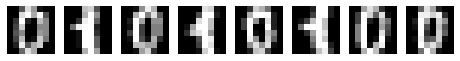

In [6]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = rd[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show() 

In [7]:
torch.save(inp, save_path + 'real.pt')

### Quantum Generator

In [8]:
# Quantum variables
n_qubits = 5  
ancillary_qubits = 1 
gen_n_layers = 10  
n_generators = 4  
image_size = 8

In [9]:
# Quantum simulator
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_generator_circuit(noise, gen_weights):

    gen_weights = gen_weights.reshape(gen_n_layers, n_qubits)

    # Encoding layer
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # PQC layers
    for i in range(gen_n_layers):

        # Rotation gates
        for y in range(n_qubits):
            qml.RY(gen_weights[i][y], wires=y)

        # Entangling gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    # Returning probability of each computational basis state
    return qml.probs(wires=list(range(n_qubits)))

In [11]:
# Testing generator circuit

noise = torch.rand(n_qubits, device=device) * math.pi / 2
gen_weights = torch.rand(gen_n_layers, n_qubits, device=device) * math.pi / 2

qgc = quantum_generator_circuit(noise, gen_weights)
qgc 

tensor([4.2397e-02, 3.5979e-02, 3.4634e-03, 1.4266e-01, 3.1627e-02, 4.0358e-02,
        3.1109e-04, 5.8988e-02, 3.2269e-02, 3.7452e-04, 2.7994e-02, 3.9425e-03,
        2.5781e-03, 7.6845e-02, 1.9407e-02, 5.7346e-02, 7.4954e-02, 7.3313e-04,
        1.6158e-02, 1.1300e-01, 2.6262e-02, 4.3200e-03, 6.1058e-05, 7.4613e-03,
        3.7146e-03, 1.5575e-04, 1.0969e-03, 1.2609e-02, 4.6322e-03, 3.3996e-02,
        1.3058e-04, 1.2418e-01], dtype=torch.float64)

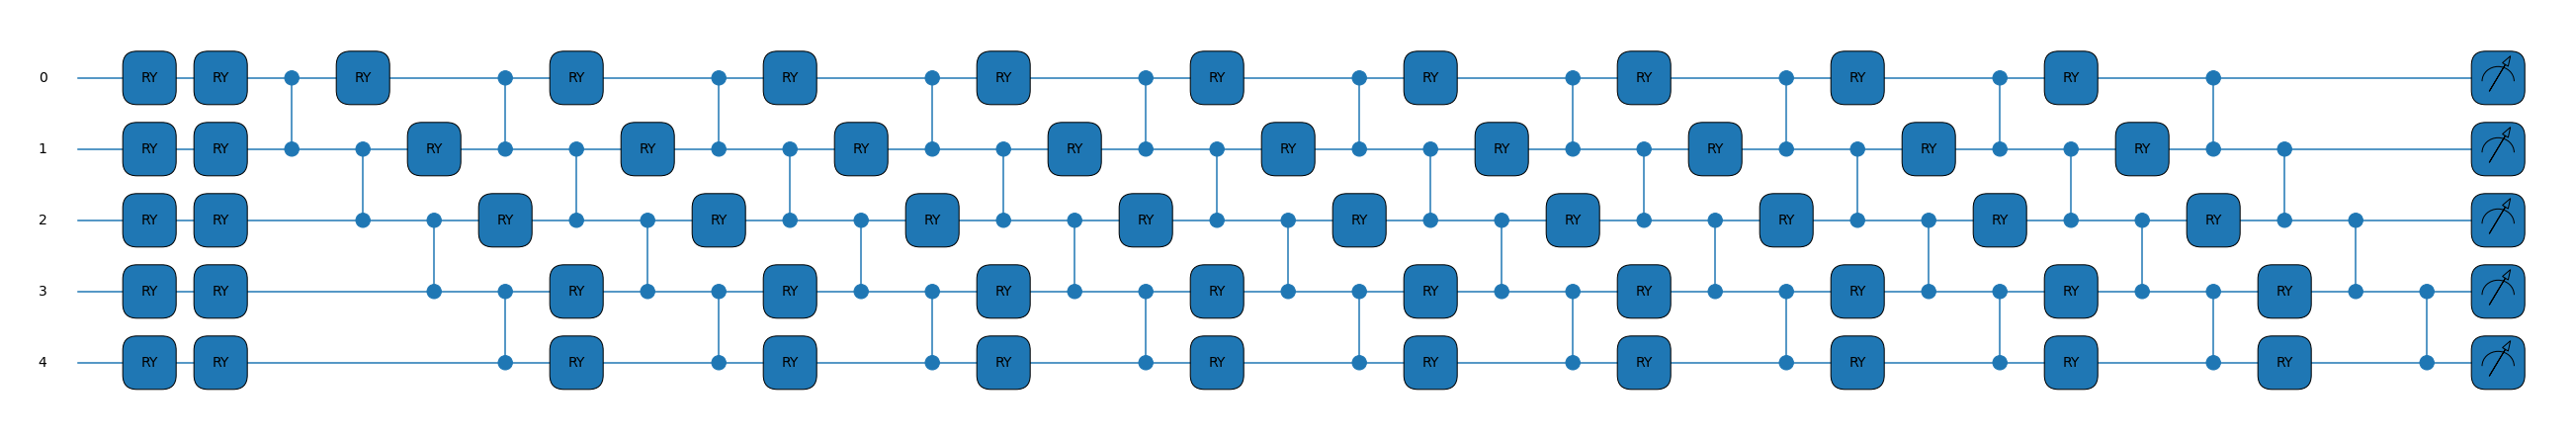

In [12]:
# Showing generator circuit
fig, ax = qml.draw_mpl(quantum_generator_circuit)(noise, gen_weights)
plt.show()

In [13]:
def partial_measure(noise, weights):
    probs = quantum_generator_circuit(noise, weights)
    partial_meas = probs[: (2 ** (n_qubits - ancillary_qubits))]
    partial_meas /= torch.sum(probs)

    # Post-Processing
    probsgiven = partial_meas / torch.max(partial_meas)
    return probsgiven

In [14]:
class QuantumGenerator(nn.Module):

    def __init__(self, n_qubits, ancillary_qubits, gen_n_layers, n_generators, q_delta=1):

        self.n_qubits = n_qubits
        self.ancillary_qubits = ancillary_qubits
        self.gen_n_layers = gen_n_layers
        self.n_generators = n_generators

        super().__init__()

        self.q_params = nn.ParameterList([nn.Parameter(q_delta * torch.rand(self.gen_n_layers * self.n_qubits), 
                                          requires_grad=True)for _ in range(self.n_generators)])

    def forward(self, x):
        
        patch_size = 2 ** (n_qubits - ancillary_qubits)

        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:

                probs = quantum_generator_circuit(elem, params)
                partial_meas = probs[: (2 ** (n_qubits - ancillary_qubits))]
                partial_meas /= torch.sum(probs)

            
                out = partial_meas / torch.max(partial_meas)
                out = out.float().unsqueeze(0)
                patches = torch.cat((patches, out))

            # define the image
            images = torch.cat((images, patches), 1)

        return images

In [15]:
# Testing quantum generator
fixed_noise = torch.rand(1, n_qubits, device=device) #* np.pi / 2

generator = QuantumGenerator(n_qubits = 5, ancillary_qubits = ancillary_qubits, 
                                  gen_n_layers = gen_n_layers, n_generators = 4).to(device)
test_images = generator(fixed_noise).view(1,1,8,8).cpu().detach()
test_images.shape

torch.Size([1, 1, 8, 8])

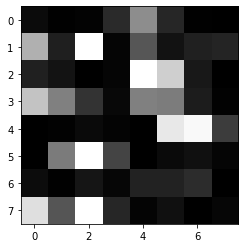

In [16]:
images = torch.squeeze(test_images, dim=1)
for j, im in enumerate(images):
    plt.imshow(im.numpy(), cmap="gray")
    
plt.show()

In [17]:
generator.parameters

<bound method Module.parameters of QuantumGenerator(
  (q_params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 50]
      (1): Parameter containing: [torch.FloatTensor of size 50]
      (2): Parameter containing: [torch.FloatTensor of size 50]
      (3): Parameter containing: [torch.FloatTensor of size 50]
  )
)>

### Discriminator Network

In [18]:
class Discriminator(nn.Module):

    def __init__(self, image_size):
        super().__init__()

        self.image_size = image_size

        self.model = nn.Sequential(
                                    # Inputs to first hidden layer (num_input_features -> 64)
                                    nn.Linear(self.image_size * self.image_size, 64),
                                    nn.ReLU(),
                                    # First hidden layer (64 -> 16)
                                    nn.Linear(64, 16),
                                    nn.ReLU(),
                                    # Second hidden layer (16 -> output)
                                    nn.Linear(16, 1),
                                    nn.Sigmoid(),
                                    )

    def forward(self, x):
        return self.model(x)

In [19]:
# Testing discriminator network

real_data = rd[0][0]
fake_data = test_images

disc = Discriminator(image_size)

In [20]:
summary(disc, input_size=(64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           4,160
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 16]           1,040
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 1]              17
           Sigmoid-6                    [-1, 1]               0
Total params: 5,217
Trainable params: 5,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


### Training class

In [21]:
class QGAN():
    def __init__(self, dataloader, gen_net, disc_net, n_qubits, image_size, batch_size, lrG, lrD, gen_loss, disc_loss):

        self.dataloader = dataloader
        self.gen_net = gen_net
        self.disc_net = disc_net
        self.n_qubits = n_qubits
        self.image_size = image_size
        self.batch_size = batch_size
        self.lrG = lrG
        self.lrD = lrD
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

        # Optimisers
        self.optD = optim.SGD(self.disc_net.parameters(), lr=self.lrD)
        self.optG = optim.SGD(self.gen_net.parameters(), lr=self.lrG)

        self.real_labels = torch.full((self.batch_size,), 1.0, dtype=torch.float, device=device)
        self.fake_labels = torch.full((self.batch_size,), 0.0, dtype=torch.float, device=device)  

        self.loss_g, self.loss_d = [], []  
        #self.total_fid = []                       

    # def generated_and_save_images(self, results):

    #     fig = plt.figure(figsize=(20, 10))
    #     outer = gridspec.GridSpec(5, 2, wspace=0.1)

    #     for i, images in enumerate(results):
    #         inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0), subplot_spec=outer[i])
            
    #         images = torch.squeeze(images, dim=1)
    #         for j, im in enumerate(images):

    #             ax = plt.Subplot(fig, inner[j])
    #             ax.imshow(im.numpy(), cmap="gray")
    #             ax.set_xticks([])
    #             ax.set_yticks([])
    #             if j==0:
    #                 ax.set_title(f'Iteration {50+i*50}', loc='left', color = 'White')
    #             fig.add_subplot(ax)

    #     plt.show()

    # def calculate_fid(self, dist1, dist2):

    #     # calculate mean and covariance statistics
    #     mu1, sigma1 = dist1.mean(axis=0), cov(dist1, rowvar=False)
    #     mu2, sigma2 = dist2.mean(axis=0), cov(dist2, rowvar=False)
        
    #     # calculate sum squared difference between means
    #     ssdiff = torch.sum((mu1 - mu2)**2.0)
    #     # calculate sqrt of product between cov
    #     covmean = sqrtm(sigma1.dot(sigma2))

    #     # check and correct imaginary numbers from sqrt
    #     if iscomplexobj(covmean):
    #         covmean = covmean.real
            
    #     # calculate score
    #     fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    #     return fid

    def train_step(self, data):

        data = data.reshape(-1, self.image_size * self.image_size)
        real_data = data.to(device)

        noise = torch.rand(self.batch_size, self.n_qubits, device=device) 
        fake_data = self.gen_net(noise)

        # Discriminator training
        self.disc_net.zero_grad()
        outD_real = self.disc_net(real_data).view(-1)
        outD_fake = self.disc_net(fake_data.detach()).view(-1)

        errD_real = self.disc_loss(outD_real, self.real_labels)
        errD_fake = self.disc_loss(outD_fake, self.fake_labels)
     
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        self.optD.step()

        # Generator training
        self.gen_net.zero_grad()
        outD_fake = self.disc_net(fake_data).view(-1)
        errG = self.gen_loss(outD_fake, self.real_labels)

        errG.backward()
        self.optG.step()

        return errG, errD


    def learn(self, epochs):

        
        self.fixed_noise = torch.rand(8, self.n_qubits, device=device) 

        
        epoch = 0      

        results = []

        with alive_bar(epochs, force_tty = True) as bar:

            while True:
                
                for _, (data, _) in enumerate(self.dataloader):

                    lg, ld = self.train_step(data)                
                    
                    epoch += 1

                    #time.sleep(0.05) 
                    bar()                   

                    # Show loss values         
                    if epoch % 10 == 0:
                        #print(f'Iteration: {epoch}, Generator Loss: {lg:0.3f}, Discriminator Loss: {ld:0.3f}')
                        test_images = self.gen_net(self.fixed_noise).view(8,1,self.image_size,self.image_size).cpu().detach()
                        torch.save(self.gen_net, save_path + f'q_gen_epoch_{epoch}')
                        #torch.save(self.gen_net.state_dict(), save_path + f'q_gen_epoch_{epoch}')
                        
                        # Save images every 50 iterations
                        if epoch % 50 == 0:
                            results.append(test_images)  
                            torch.save(results, save_path + 'synthetic.pt')     
                            #fid = self.calculate_fid(data[0], results[0][0][0])  
                            #self.total_fid.append(fid.item())                               
                    
                    self.loss_g.append(lg.detach().numpy())
                    self.loss_d.append(ld.detach().numpy())      

                    if epoch == epochs:
                        break
                if epoch == epochs:
                    break                  
                           
            #torch.save(loss_g, save_path + 'gen_loss.pt') 
            #torch.save(loss_d, save_path + 'disc_loss.pt')
            #torch.save(self.total_fid, save_path + 'fid.pt')  
        
        #self.generated_and_save_images(results)
        # plt.figure(figsize=(11, 7))
        # plt.plot(np.arange(epochs), self.loss_g, color = 'Red', label = 'Generator Loss\n120 parameters')
        # plt.plot(np.arange(epochs), self.loss_d, color = 'Blue', label = 'Discriminator Loss\n5217 parameters')
        # plt.xlabel('Epochs', fontsize = 16)
        # plt.ylabel('Loss', fontsize = 16)
        # plt.legend(loc = 'upper right', fontsize = 16)
        # plt.show()

In [22]:
n_qubits = 5
ancillary_qubits = 1
gen_n_layers = 8
n_generators = 4
image_size = 8
batch_size = 1
loss = nn.BCELoss()
lrG = 0.3
lrD = 0.01
epochs = 1500

|████████████████████████████████████████| 1500/1500 [100%] in 39:26.2 (0.63/s)                                         


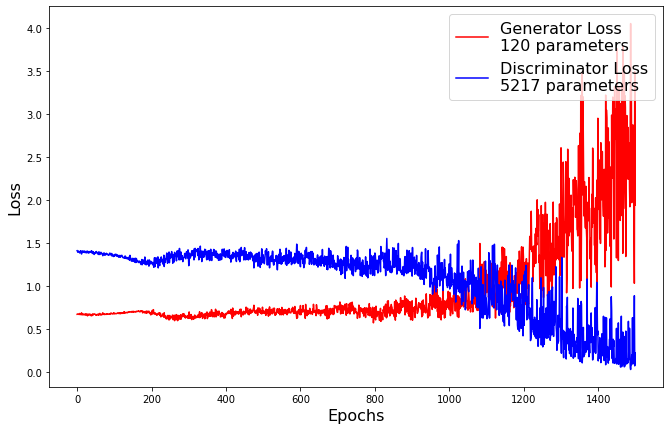

In [23]:
gen_net = QuantumGenerator(n_qubits = n_qubits, ancillary_qubits = ancillary_qubits, 
                           gen_n_layers = gen_n_layers, n_generators = n_generators).to(device)
disc_net = Discriminator(image_size).to(device)

runs = 1

loss_g_mean = []
loss_d_mean = []
#fid_mean = []

for run in range(runs): 

    qgan = QGAN(dataloader = dataloader, gen_net = gen_net, disc_net = disc_net, n_qubits = n_qubits, image_size = image_size, 
            batch_size = batch_size, lrG = lrG, lrD = lrD, gen_loss = loss, disc_loss = loss)

    qgan.learn(epochs)

    loss_g_mean.append(qgan.loss_g)
    loss_d_mean.append(qgan.loss_d)
    #fid_mean.append(qgan.total_fid)
    
    torch.save(loss_g_mean, save_path + 'gen_loss.pt') 
    torch.save(loss_d_mean, save_path + 'disc_loss.pt') 
   #torch.save(fid_mean, save_path + 'fid.pt')

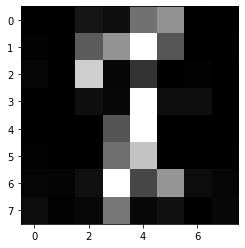

torch.Size([1, 8, 8])

In [25]:
#model = QGAN(dataloader = dataloader, gen_net = gen_net, disc_net = disc_net, z_dim = 5, image_size = image_size, 
#                batch_size = batch_size, lrG = lrG, lrD = lrD, gen_loss = loss, disc_loss = loss)
#model.gen_net.load_state_dict(torch.load('torch_results/QGAN/QGAN_linear/20221215-143324/qgen_epoch_1500'))
#model.gen_net.eval()

QGAN_imgs = []
for i in range(360):      
    fixed_noise = torch.rand(1, 5)  
    image = qgan.gen_net(fixed_noise).view(1,8,8).cpu().detach()
    QGAN_imgs.append(image)

torch.save(QGAN_imgs, save_path + 'qgan_inference_data.pt') 

plt.imshow(QGAN_imgs[11][0], cmap="gray")
    
plt.show()
QGAN_imgs[0].shape